# *Machine Learning*
# Aplicación de clasificación de imágenes multi-espectrales de satélite en la cual se dispone de un conjunto de muestras etiquetadas con sus clases correspondientes.

*Carolina Giménez Arias*

# 1. Importación y preparación del dataset

Comenzamos importando las librerías con las que vamos a trabajar:

In [1]:
import numpy as np
import scipy.io.matlab as matlab
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.cluster import estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

A continuación, se lee y a almacena la imagen que se nos ha sido proporcionada

In [2]:
np.random.seed(12)
# Lectura de la imagen de fichero de Matlab .mat
mat_file =  "datasetB5.mat"
mat = matlab.loadmat(mat_file,squeeze_me=True) #devuelve un dictionary
list(mat.keys()) #variables almacenadas

['__header__', '__version__', '__globals__', 'Xl', 'Yl', 'metadata', 'X']

In [3]:
# Lectura de los datos
X = mat["X"]   #imagen (hipercubo 3D: filas x columnas x variables) 
Xl = mat["Xl"]   #muestras etiquetadas (muestas x variables) 
Yl = mat["Yl"]   #etiquetas de clases (muestras x 1, 0=sin clase)   
del mat
Yl.shape

(158253,)

In [4]:
# Reshape del Ground Truth como una imagen
Y = np.reshape(Yl, (X.shape[0], X.shape[1]),order="F")
Y.shape

(321, 493)

In [5]:
# Filter background: eliminamos la clase 0 de los datos etiquetados
Nc=Yl.max()-Yl.min()+1
if Nc>2:
    Xl = Xl[Yl != 0,:];
    Yl = Yl[Yl != 0];

Mostramos la imagen original (uno de sus canales) junto con su correspondiente _groundtruth_, es decir, las etiquetas verdaderas a nivel de pixel. El _groundtruth_ disponible distingue entre dos clases, que parecen corresponderse con la pertenencia o la no pertenencia de cada píxel a una nube.

(<matplotlib.image.AxesImage at 0xb0cb41710>,
 (-0.5, 492.5, 320.5, -0.5),
 Text(0.5,1,'Ground Truth'))

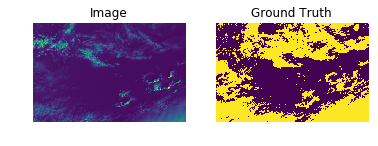

In [6]:
# Dibujamos las imagenes
ax=plt.subplot(1,2,1)
ax.imshow(X[:,:,1]), ax.axis('off'), plt.title('Image')
ax=plt.subplot(1,2,2)
ax.imshow(Y), ax.axis('off'), plt.title('Ground Truth')

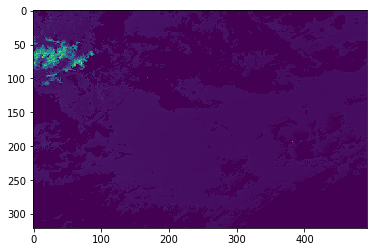

In [7]:
# Dibujamos los resultados
clasmap=Y;
clasmap_masked = np.ma.masked_where(clasmap<1,clasmap)
plt.imshow(X[:,:,1])
plt.imshow(clasmap_masked)

Se aprecia como, en función del canal que escojamos para representar la imagen, se distingue de forma más clara unos detalles de la imagen u otros. Por ejemplo, el canal 12 proporciona un mayor contraste en la imagen, lo que nos ha permitido diferenciar la existencia de lo que parece una región con tierra rodeada de mar cubierta con nubes de distintas densidades. Concretamente, parece corresponderse con la costa de la parte superior de Cataluña, por lo que suponemos que la región similar a las nubes en la esquina superior izquierda que no está marcada en el _groundtruth_ podría corresponderse con el terreno montañoso de los Pirineos. De aquí en adelante nos referiremos a esta parte de la imagen como "nieve".

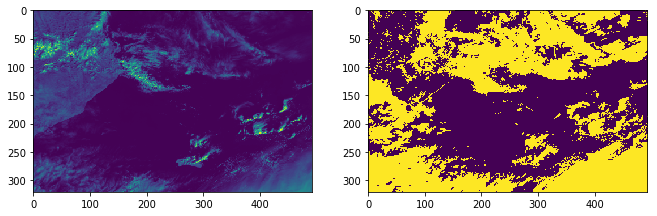

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(11,12))
ax = axes.ravel()
ax[0].imshow(X[:,:,12])
ax[1].imshow(Y)

Para la realización de este trabajo emplearemos inicialmente las 15 bandas disponibles.

# 2. Aprendizaje no supervisado

Para llevar a cabo la clasificación de los datos proporcionados se seguirán distintas estrategias. En primer lugar, se propone emplear métodos de aprendizaje no supervisado, que en lugar de clasificar los píxeles teniendo en cuenta las etiquetas de las que disponemos pretenden agrupar los datos según su semejanza o proximidad, siguiendo un criterio u otro según el método empleado. También se utilizarán métodos de aprendizaje supervisado más adelante, los cuales sí que emplean las etiquetas del _groundtruth_ para entrenar modelos de clasificación.

## 2.1 Clustering

Debido a que se dispone de una muestra de datos muy extensa y a que es probable que estos se distribuyan de una manera compleja, a la hora de hacer la partición de los datos utilizaremos métodos de clustering. Estos tienen como objetivo encontrar agrupaciones de muestras con características similares, de este modo, garantizaremos obtener una muestra reducida lo suficientemente representativa de nuestro subconjunto como para trabajar con ella.

### 2.1.1 K-means

En primer lugar hemos decidido usar el algoritmo de clustering K-Means o K-medias, pues es uno de los algoritmos de agrupación más antiguos y más empleados. El objetivo de este algoritmo es encontrar K clusters en los que agrupar los datos, basándose en su proximidad (utilizando la distancia euclídea). 

Para implementar este algoritmo escogeremos un total de 2 clusters, partiendo de la idea de separar los píxeles de nuestra imagen en dos grupos en función de si el píxel escogido se trata de una nube o no forma parte de una nube. Para sustentar esta hipótesis hemos decidido calcular la puntuación de Silhouette, para así determinar cuál es el mejor número de clusters que este detecta y si este resultado coincide con nuestro razonamiento.

In [9]:
[m, n, k] = X.shape
matriz = np.reshape(X,(m*n,k))

In [10]:
#Silhouette
matriz_mini=matriz[:10000]
rango_clusters = [2, 3, 4]
best_score=0

for n_clusters in rango_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=6)
    cluster_labels = clusterer.fit_predict(matriz_mini)
    # Puntuación silhouette media para cada número de clusters
    silhouette_avg = silhouette_score(matriz_mini, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "el silhouette_score medio es :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score=silhouette_avg
        best_n_clusters=n_clusters
    # Calculamos el valor del silhouette para cada muestra
    sample_silhouette_values = silhouette_samples(matriz_mini, cluster_labels)

print("El mejor número de clusters es ",best_n_clusters)

Para n_clusters = 2 el silhouette_score medio es : 0.8020178810438109
Para n_clusters = 3 el silhouette_score medio es : 0.6595664111586335
Para n_clusters = 4 el silhouette_score medio es : 0.6436317148809633
El mejor número de clusters es  2


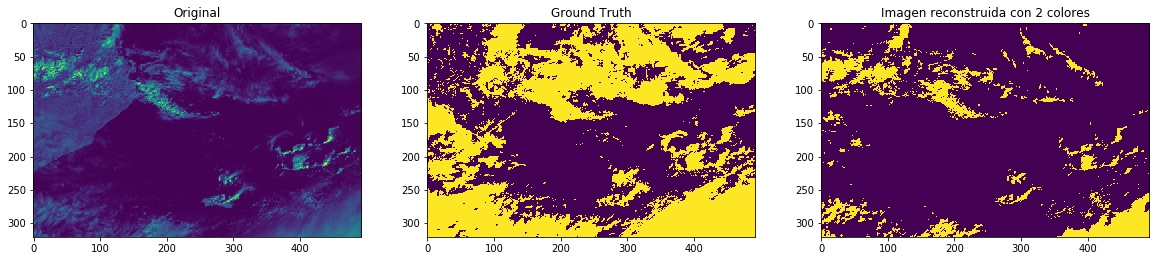

In [11]:
[m, n, k] = X.shape
matriz = np.reshape(X,(m*n,k))
ns_clusters = 2

for n_clusters in [ns_clusters]:
    kmeans=KMeans(n_clusters=n_clusters)
    kmeans.fit(matriz)
    labels=kmeans.labels_
    resultado = np.reshape(labels,(m,n))
       
fig, axes = plt.subplots(1, 3, figsize=(20,20))
ax = axes.ravel()
    
ax[0].imshow(X[:,:,12])
ax[0].set_title("Original")
ax[1].imshow(Y)
ax[1].set_title("Ground Truth")
ax[2].set_title("Imagen reconstruida con "+ str(n_clusters) +" colores")
ax[2].imshow(resultado)

Calculamos el rendimiento de este algoritmo (y de todos los que se desarrollarán a continuación) comparando la etiqueta predicha con la real píxel a píxel:

In [12]:
# Evaluamos la calidad de la clasificación calculando distintas métricas:
cm = confusion_matrix(np.reshape(Y,(m*n)),labels)
print("Matriz de confusión: \n",cm)
print("Sensibilidad:", np.round(cm[0,0]/(cm[0,0]+cm[1,0]),4))
print("Especificidad:", np.round(cm[1,1]/(cm[1,1]+cm[0,1]),4))
print("Exactitud:", round(accuracy_score(np.reshape(Y,(m*n)),labels),4))

Matriz de confusión: 
 [[83535  2284]
 [55278 17156]]
Sensibilidad: 0.6018
Especificidad: 0.8825
Exactitud: 0.6363


Tal y como se observa cualitativamente, los resultados obtenidos no han sido satisfactorios, reportando un 60% de sensibilidad y un 88% de especificidad aproximadamente. Probablemente la sensibilidad sea tan baja debido a que el algoritmo tan solo ha reconocido como nubes aquellas que eran más intensas y fácilmente reconocibles, por lo que muchas zonas que debían estar marcadas como nube no lo están. Aunque la especificidad es más alta, tampoco ha obtenido un valor alto, pues una fracción más o menos grande de los píxeles marcados como "nube" corresponden a la zona en la tierra que habíamos denominado "nieve", que aunque a simple vista podría parecer una nube, no había sido etiquetada como tal en el _groundtruth_.

El motivo de que los resultados no hayan sido satisfactorios puede residir en que el algoritmo k-medias asume una distribución hiperesférica de los datos de una clase, quedando todos más o menos alrededor de un _centroide_ o centro del clúster, caso que puede no darse en los datos de nuestro problema.

### 2.1.2 Mean-shift

El método mean-shift forma parte de la familia de algoritmos de clustering que organizan grupos basándose en la densidad espacial de muestras. Debido a la extensa cantidad de muestras y al coste computacional que supone trabajar con esta técnica, seleccionaremos una zona pequeña cualquiera de la imagen (X2) para garantizar que pueda procesarse en un tiempo razonable y así poder ilustrar este método.

In [13]:
# Seleccionamos una zona de la imagen y un número de clusters
X2 = X[100:150,200:300,:]
[m, n, k] = X2.shape
ms_matriz = np.reshape(X2,(m*n,k))
ns_clusters = 2

Para implementar este método será necesario especificar el _bandwidth_ del kernel. El bandwith óptimo puede ser calculado con la función *estimate_bandwidth*. Sin embargo, tras emplearla hemos comprobado cómo esta función requiere un tiempo de computación bastante largo y el resultado obtenido proporcionaba resultados insatisfactorios, pues no consigue separar los datos en distintos grupos, cayendo todas las muestras (o la mayoría) en una única clase. Para encontrar un valor conveniente, se ha probado a utilizar distintos valores y determinar con cuál logra la mejor clasificación. 

Rendimiento con una bandwidth = 0.01
Matriz de confusión: 
 [[2316  510]
 [   0 2174]]
Sensibilidad: 1.0
Especificidad: 0.81
Exactitud: 0.898


Rendimiento con una bandwidth = 0.02
Matriz de confusión: 
 [[2567  259]
 [   0 2174]]
Sensibilidad: 1.0
Especificidad: 0.8935
Exactitud: 0.9482


Rendimiento con una bandwidth = 0.2
Matriz de confusión: 
 [[2826    0]
 [ 890 1284]]
Sensibilidad: 0.7605
Especificidad: 1.0
Exactitud: 0.822


Rendimiento con una bandwidth = 0.25
Matriz de confusión: 
 [[2826    0]
 [1640  534]]
Sensibilidad: 0.6328
Especificidad: 1.0
Exactitud: 0.672




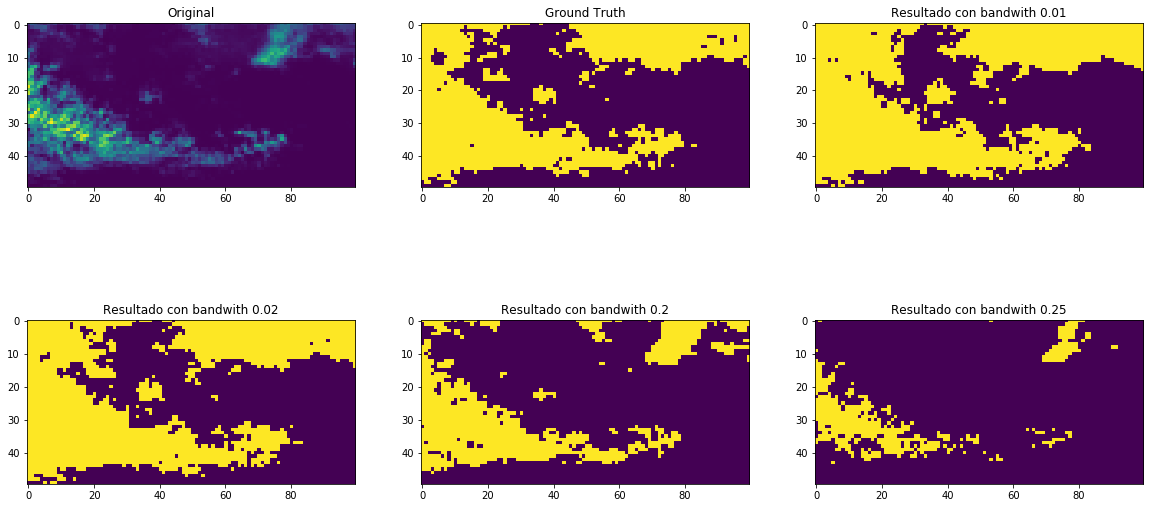

In [14]:
# Estimamos el bandwidth óptimo:
# bandwidth=estimate_bandwidth(matriz) #El resultado da 0.28, pero con eso se pasa.
bandwidths=[0.01,0.02,0.2,0.25]

# Graficamos las distintas imágenes
fig, axes = plt.subplots(2, 3, figsize=(20,10))
ax = axes.ravel()
ax[0].imshow(X2[:,:,12])
ax[0].set_title("Original")
ax[1].imshow(Y[100:150,200:300])
ax[1].set_title("Ground Truth")

# Entrenamos el modelo usando la matriz de píxeles escogida y observamos los resultados de
# cada agrupamiento
for i,bandwidth in enumerate(bandwidths):
    clustering2 = MeanShift(bandwidth=bandwidth).fit(ms_matriz)
    labels = clustering2.labels_
    labels[labels>0]=1
    resultado = np.reshape(labels,(m,n))

    ax[i+2].set_title("Resultado con bandwith "+ str(bandwidth))
    ax[i+2].imshow(resultado)
    
    cm = confusion_matrix(np.reshape(Y[100:150,200:300],m*n),labels)
    print("Rendimiento con una bandwidth =",bandwidth)
    print("Matriz de confusión: \n", cm)
    print("Sensibilidad:", np.round(cm[0,0]/(cm[0,0]+cm[1,0]),4))
    print("Especificidad:", np.round(cm[1,1]/(cm[1,1]+cm[0,1]),4))
    print("Exactitud:", round(accuracy_score(np.reshape(Y[100:150,200:300],m*n),labels),4))
    print('\n')

El mejor resultado se ha obtenido con un bandwidth=0.02. Esta superioridad en los resultados se refleja también claramente al reconstruir las máscaras con las etiquetas y compararlas con el *groundtruth*.

## 2.2 Modelos de mixturas

Los modelos de mixturas son utilizados para la modelización de datos heterogéneos en multitud de situaciones experimentales, en donde aquellos pueden interpretarse como procedentes de dos o más subpoblaciones, motivo por el cual hemos pensado que sería interesante emplear uno de estos algoritmos para modelizar nuestros datos.

### 2.2.1 Expectation-Maximization

El algoritmo de expectation-maximization se usa en estadística para encontrar estimadores de máxima verosimilitud de parámetros en modelos probabilísticos que dependen de variables no observables y es uno de los algoritmos de modelos de mixturas más comúnmente conocido.

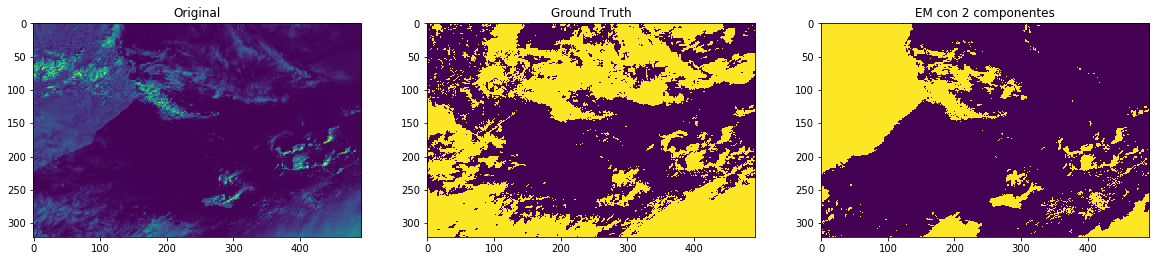

In [15]:
#Definimos la matriz de píxeles y los componentes a usar para llevar a cabo la mixtura gaussiana
[m, n, k] = X.shape
matriz = np.reshape(X,(m*n,k))
n_components = 2

# Modelo EM
EM = GaussianMixture(n_components=n_components)
EM.fit(matriz)
y_pred = EM.predict(matriz)
resultado = y_pred.reshape(m,n)

# Visualizamos los resultados
fig, axes = plt.subplots(1, 3, figsize = (20,20))
ax = axes.ravel()
ax[0].imshow(X[:,:,12])
ax[0].set_title("Original")
ax[1].imshow(Y)
ax[1].set_title("Ground Truth")
ax[2].set_title("EM con "+ str(n_components) + " componentes")
ax[2].imshow(resultado)

In [16]:
# Analizamos resultados
cm = confusion_matrix(Yl,y_pred)
print("Matriz de confusión: \n", cm)
print("Sensibilidad:", np.round(cm[0,0]/(cm[0,0]+cm[1,0]),4))
print("Especificidad:", np.round(cm[1,1]/(cm[1,1]+cm[0,1]),4))
print("Exactitud:", round(accuracy_score(np.reshape(Y,(m*n)),y_pred),4))

Matriz de confusión: 
 [[62138 23681]
 [53206 19228]]
Sensibilidad: 0.5387
Especificidad: 0.4481
Exactitud: 0.6133


Los resultados de la clasificación han sido bastante poco satisfactorios, quizás debido a que en nuestro caso el algoritmo EM no era la técnica más indicada, pues tal y como se ha comentado, este algoritmo es especialmente útil en casos donde tenemos información faltante o variables ocultas, y no tanto en clasificación. Además, el método asume que los clusters siguen distribuciones normales, lo cual podría no ser cierto.

# 3. Aprendizaje supervisado

## 3.1 Preparación del dataset

Al utilizar algoritmos de aprendizaje supervisado simularemos la escasez de muestras etiquetadas empleando solo 5000 muestras (con sus etiquetas correspondientes). Para seleccionarlas utilizaremos, en primer lugar, algoritmos de clustering que agrupen los píxeles de cada clase en una serie de "subclases" cuyos píxeles tengan características más afines entre sí. Una vez clasificados, se seleccionarán convenientemente de forma que la muestra inframuestreada preserve la distribución de los datos de entrada originales.

En primer lugar separaremos los datos en función de sus etiquetas en las clases "nube" y "no nube":

In [16]:
# Definimos dos matrices con las etiquetas 0 (no nube) y 1 (nube)
[m, n, k] = X.shape
matriz = np.reshape(X,(m*n,k))
y = np.reshape(Y,(m*n))
matriz_nonube = matriz[y == 0]
matriz_nube = matriz[y == 1]

A continuación se procede a la aplicación de un algoritmo de clustering para agrupar los píxeles de características próximas dentro de cada clase. Concretamente, utilizaremos k-Means, pues es el que mejores resultados ha proporcionado anteriormente. Se siguen unos pasos similares a los del apartado 2.1.2:

Para escoger un número de clusters adecuado, se se analizarán los scores en el *Silhouette*. Para ello será necesario subsamplear la muestra de datos por problemas relacionados con el tamaño de memoria de los equipos utilizados. En este caso, seleccionaremos dos matrices denominadas *matriz_nonube_mini* y *matriz_nube_mini*, con las que trabajaremos para estimar el _Silhouette score_ de los datos completos. 

A su vez, será necesario determinar un rango de clusters que probar para finalmente escoger el más indicado en función del *Silhouette score*. Nos fijaremos en el valor promedio de las puntuaciones de todas las muestras de un cluster, que aportan una perspectiva de la densidad y separación de las muestras en los clusters formados.

Empezamos con la clase **"no nube"**:

In [17]:
#Silhouette
matriz_nonube_mini = matriz_nonube[:10000]
rango_clusters = [2, 3, 4]
best_score = 0

for n_clusters in rango_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=6)
    cluster_labels = clusterer.fit_predict(matriz_nonube_mini)
    # Puntuación silhouette media para cada número de clusters
    silhouette_avg = silhouette_score(matriz_nonube_mini, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El silhouette_score medio es :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
    # Calculamos el valor del silhouette para cada muestra
    sample_silhouette_values = silhouette_samples(matriz_nonube_mini, cluster_labels)

print("El mejor número de clusters es ",best_n_clusters)

Para n_clusters = 2 El silhouette_score medio es : 0.8564035629709813
Para n_clusters = 3 El silhouette_score medio es : 0.7648876593635581
Para n_clusters = 4 El silhouette_score medio es : 0.7466407634167878
El mejor número de clusters es  2


Tal y como se observa en los resultados, con un total de 2 clusters la puntuación _silhouette_ media es mayor, lo que lleva a pensar que el mejor número de clusters con el que realizar K-Means es 2. A pesar de ello, si realizamos una comparativa visual de los resultados, se aprecia cómo con 3 clusters la agrupación de los píxeles en subgrupos parece mejor, quedando la tierra perfectamente separada del agua, razón por la cual hemos decidido finalmente emplear 3 clusters para llevar a cabo el K-Means.

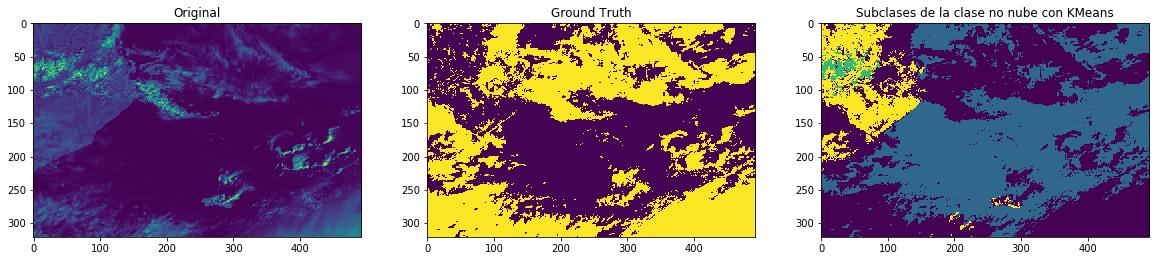

In [18]:
# KMeans 
n_clusters = 3 
kmeans = KMeans(n_clusters =n_clusters)
kmeans.fit(matriz_nonube)
labels = kmeans.labels_
ind_nonube = np.where(y == 0)

resultado = np.zeros(m*n)
resultado[ind_nonube] = labels + 1
resultado = np.reshape(resultado,(m,n))
    
fig, axes = plt.subplots(1, 3, figsize=(20,20))
ax = axes.ravel()

ax[0].imshow(X[:,:,12])
ax[0].set_title("Original")
ax[1].imshow(Y)
ax[1].set_title("Ground Truth")
ax[2].set_title("Subclases de la clase no nube con KMeans")

ax[2].imshow(resultado)

El la imagen de la derecha se observa cómo la clase "no nube" ha sido dividida en lo que parece ser "mar", "tierra" y "nieve".

Tal y como se indica en el enunciado de este trabajo, para aplicar los algoritmos de aprendizaje supervisado se simulará la escasez de muestras etiquetadas empleando solo 5000 muestras con sus etiquetas. Para ello, seleccionaremos únicamente 2500 muestras de la matriz _no nube_, para más tarde seleccionar otras 2500 muestras de la matriz _nube_:

In [19]:
#Seleccionamos 2500 de no nube:
best_n_clusters = 3 #Porque lo decimos nosotros
nonube_undersampled = np.zeros((1,15))
for n in range(best_n_clusters):
    samples_cluster_n = matriz_nonube[labels == n]
    porcentaje_n = sum(labels == n)/len(labels)
    subseleccion=np.random.randint(0,sum(labels == n),int(round(2500*porcentaje_n)))
    nonube_undersampled = np.append(nonube_undersampled,samples_cluster_n[subseleccion],axis = 0)
nonube_undersampled = nonube_undersampled[1:]
np.shape(nonube_undersampled)

(2500, 15)

Una vez preparadas las 2500 muestras de la clase "no nube", pasamos a repetir el proceso con la clase **"nube"**:

In [20]:
#Silhouette
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

#Probaremos con 
matriz_nube_mini = matriz_nube[:10000]
rango_clusters = [2, 3, 4]
best_score = 0

for n_clusters in rango_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=6)
    cluster_labels = clusterer.fit_predict(matriz_nube_mini)

    # Puntuación silhouette media para cada número de clusters
    silhouette_avg = silhouette_score(matriz_nube_mini, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El silhouette_score medio es :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score=silhouette_avg
        best_n_clusters=n_clusters
    # Calculamos el valor del silhouette para cada muestra
    sample_silhouette_values = silhouette_samples(matriz_nube_mini, cluster_labels)
    
print("El mejor número de clusters es ", best_n_clusters)

Para n_clusters = 2 El silhouette_score medio es : 0.7599807003586402
Para n_clusters = 3 El silhouette_score medio es : 0.6515933473415725
Para n_clusters = 4 El silhouette_score medio es : 0.6145829374011375
El mejor número de clusters es  2


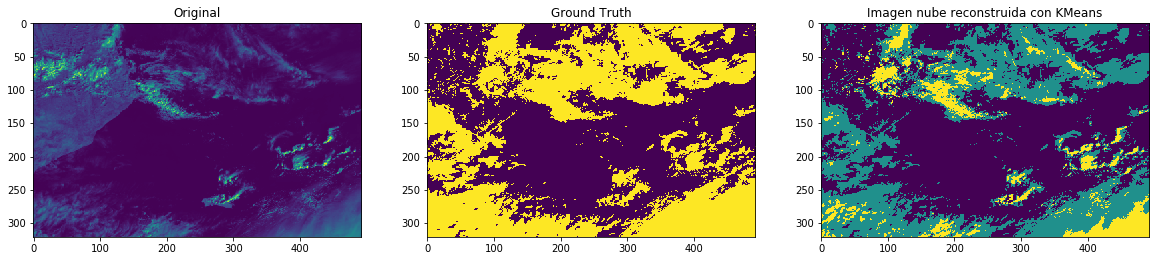

In [21]:
# KMeans 
[m, n, k] = X.shape
matriz = np.reshape(X,(m*n,k))
y = np.reshape(Y,(m*n))
matriz_nube = matriz[y == 1]
n_clusters = best_n_clusters
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(matriz_nube)
labels=kmeans.labels_
ind_nube = np.where(y == 1)

resultado = np.zeros(m*n)
resultado[ind_nube] = labels+1
resultado = np.reshape(resultado,(m,n))
    
fig, axes = plt.subplots(1, 3, figsize=(20,20))
ax = axes.ravel()

ax[0].imshow(X[:,:,12])
ax[0].set_title("Original")
ax[1].imshow(Y)
ax[1].set_title("Ground Truth")
ax[2].set_title("Imagen nube reconstruida con KMeans")

ax[2].imshow(resultado)

Vemos cómo en este caso la clase "nube" ha sido separada entre aquellas más intensas y las más difíciles de ver.

Seleccionamos ahora 2500 muestras de la matriz de píxeles nube y llevamos a cabo un proceso similar para obtener los valores del *Silhouette score*.

In [22]:
#Seleccionamos 2500 de nube:
nube_undersampled = np.zeros((1,15))
for n in range(best_n_clusters):
    samples_cluster_n = matriz_nube[labels == n]
    #scores_cluster_n = sample_silhouette_values[labels==n]
    porcentaje_n = sum(labels == n)/len(labels)
    #ranking=np.argsort(scores_cluster_n)
    subseleccion = np.random.randint(0,sum(labels == n),int(np.round(2500*porcentaje_n)))
    nube_undersampled = np.append(nube_undersampled,samples_cluster_n[subseleccion],axis=0)
nube_undersampled = nube_undersampled[1:]
np.shape(nube_undersampled)

(2500, 15)

Juntamos las dos matrices en una única matriz con las etiquetas correspondientes:

In [23]:
matriz_under = np.append(nonube_undersampled,nube_undersampled,axis=0)
labels_under = np.append(np.zeros(np.shape(nonube_undersampled)[0]),np.ones(np.shape(nube_undersampled)[0]))
np.shape(labels_under)

(5000,)

A continuación llevamos a cabo la partición aleatoria en datos de test y training y fijamos una semilla:

In [24]:
np.random.seed(666) # fijamos una semilla
X_train, X_test, y_train, y_test = train_test_split(matriz_under, labels_under, test_size=.33, shuffle = True)

Para evitar cualquier sesgo en las predicciones hacia alguna de las clases suele ser de utilidad llevar a cabo un balanceo de los datos, en este caso, por _subsampling_ de la clase mayoritaria. Aunque la función anterior divide genera un conjunto de entrenamiento más o menos balanceado, consideramos que se trata de una buena praxis diseñar un método para balancear las clases.

In [25]:
exceso_negativas=int(len(y_train)-sum(y_train)*2)
if exceso_negativas > 0:
    ind0 = np.squeeze(np.where(y_train == 0))
    X_train = np.delete(X_train,ind0[0:exceso_negativas], axis = 0)
    y_train = np.delete(y_train,ind0[0:exceso_negativas], axis = 0)
elif exceso_negativas < 0:
    ind1 = np.squeeze(np.where(y_train == 1))
    X_train = np.delete(X_train,ind1[0:abs(exceso_negativas)], axis = 0)
    y_train = np.delete(y_train,ind1[0:abs(exceso_negativas)], axis = 0)

## 3.1 Algoritmos de clasificación

### 3.1.1 K-Nearest Neighbors

En primer lugar, probamos a realizar la clasificación con un algoritmo no paramétrico; en concreto hemos escogido el algoritmo *K-Nearest Neighbors* o *KNN*. Estudiaremos la clasificación con distintos números de vecinos, desde 2 hasta 9, y nos quedaremos con el número que proporcione la mayor exactitud en la clasificación. 

Este algoritmo, aunque muy conocido y fácil de entender, es muy sensible a malas características, a ruido y a la presencia de _outliers_. Sin embargo, consideramos interesante comparar su rendimiento con el de otros métodos de clasificación.

In [26]:
scores = []
for i in range(2,9):
    neigh = KNeighborsClassifier(n_neighbors = i)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
max_KNN_score = np.argmax(scores)
best_K = np.array(range(2,6)[max_KNN_score])
print("El accuracy score máximo obtenido es",scores[max_KNN_score], "con", best_K, "vecinos")

El accuracy score máximo obtenido es 0.9678787878787879 con 5 vecinos


Obtenemos la matriz de confusión y el resto de métricas con el número de vecinos que ha proporcionado mejores resultados:

In [27]:
neigh = KNeighborsClassifier(n_neighbors=best_K)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

# Analizamos resultados empleando las mismas métricas que anteriormente
cm = confusion_matrix(y_test,y_pred)
print("Matriz de confusión: \n", cm)
print("Sensibilidad:", np.round(cm[0,0]/(cm[0,0]+cm[1,0]),4))
print("Especificidad:", np.round(cm[1,1]/(cm[1,1]+cm[0,1]),4))
print("Exactitud:", round(accuracy_score(y_test, y_pred),4))

Matriz de confusión: 
 [[786  41]
 [ 12 811]]
Sensibilidad: 0.985
Especificidad: 0.9519
Exactitud: 0.9679


Comprobamos también la eficacia del método cualitativamente:

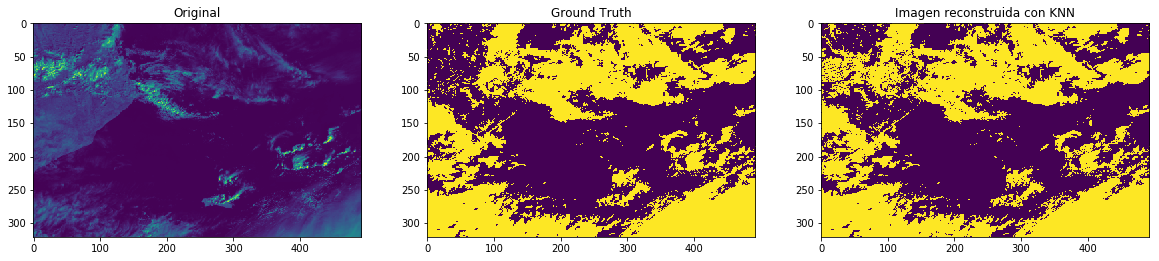

In [28]:
[m, n, k] = X.shape
matriz = np.reshape(X,(m*n,k))
resultado = neigh.predict(matriz)
resultado_knn = np.reshape(resultado+1,(m,n))
    
fig, axes = plt.subplots(1, 3, figsize=(20,20))
ax = axes.ravel()

ax[0].imshow(X[:,:,12])
ax[0].set_title("Original")
ax[1].imshow(Y)
ax[1].set_title("Ground Truth")
ax[2].set_title("Imagen reconstruida con KNN")
ax[2].imshow(resultado_knn)

Los resultados con KNN son bastante buenos, probablemente debido a que las muestras son representativas de cada una de las clases y están correctamente etiquetadas, minimizando así la presencia de ruido.

### 3.1.2 Árboles de decisión

Los árboles de decisión son algoritmos que, partiendo de las características de cada ejemplo, van generando puntos de decisión de los cuales surgen “ramas” representando las distintas alternativas, siendo la clase de los elementos en cada rama cada vez más pura hasta que se llega a clasificarlos definitivamente.

In [29]:
score=0
best_criterio='entropy'
best_depth=1
for criterio in ('entropy','gini'):
        #Calculamos la profundidad máxima del árbol
        clf = DecisionTreeClassifier(criterion=criterio)
        clf = clf.fit(X_train, y_train)
        maxd=clf.tree_.max_depth 
        state_dt=np.random.get_state()
        for prof in range(1,maxd+1):
                np.random.set_state(state_dt)
                clf = DecisionTreeClassifier(criterion=criterio, max_depth=prof) #Escogemos la estructura del modelo
                clf = clf.fit(X_train, y_train) #Entrenamos el modelo
                score2=clf.score(X_test,y_test)
                if (score2>score):
                    best_criterio=criterio
                    best_depth=prof
print('La configuración que mejor score ha proporcionado es:')
print('Criterio: ',best_criterio)
print('Profundidad: ',best_depth)

La configuración que mejor score ha proporcionado es:
Criterio:  gini
Profundidad:  17


In [30]:
clf = DecisionTreeClassifier(criterion=best_criterio, max_depth=best_depth)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Analizamos resultados empleando las mismas métricas que anteriormente
cm = confusion_matrix(y_test,y_pred)
print("Matriz de confusión: \n", cm)
print("Sensibilidad:", np.round(cm[0,0]/(cm[0,0]+cm[1,0]),4))
print("Especificidad:", np.round(cm[1,1]/(cm[1,1]+cm[0,1]),4))
print("Exactitud:", round(accuracy_score(y_test, y_pred),4))

Matriz de confusión: 
 [[790  37]
 [ 32 791]]
Sensibilidad: 0.9611
Especificidad: 0.9553
Exactitud: 0.9582


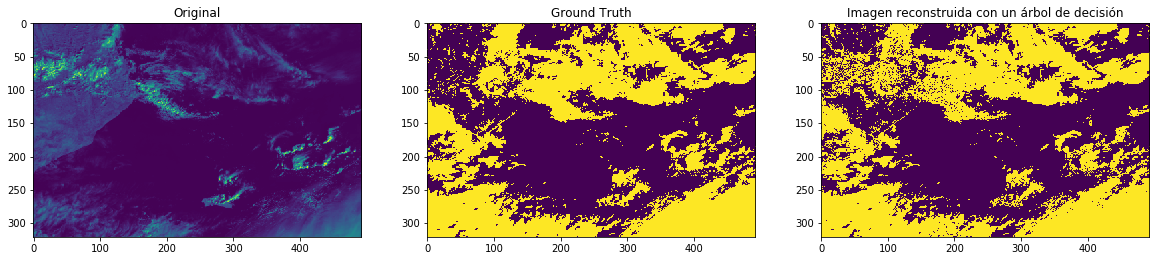

In [31]:
[m, n, k] = X.shape
matriz = np.reshape(X,(m*n,k))
resultado = clf.predict(matriz)
resultado_svm=np.reshape(resultado+1,(m,n))
    
fig, axes = plt.subplots(1, 3, figsize=(20,20))
ax = axes.ravel()

ax[0].imshow(X[:,:,12])
ax[0].set_title("Original")
ax[1].imshow(Y)
ax[1].set_title("Ground Truth")
ax[2].set_title("Imagen reconstruida con un árbol de decisión")
ax[2].imshow(resultado_svm)

Puede comprobarse tanto cuantitativamente como cualitativamente que, a pesar de ser un modelo muy sencillo, el árbol ha clasificado los píxeles con un acierto bastante aceptable.

### 3.1.3 Support Vector Machine

Con motivo de estudiar si la clasificación mejora o no al utilizar un algortimo paramétrico, probamos la técnica *Support Vector Machine*:

In [32]:
#Para comparar con implementaciones de SVM posteriores, obtenemos el estado aleatorio actual:
estado_svm = np.random.get_state()
#En este caso seleccionamos el kernel rbf porque el lineal es demasiado simple para nuestro modelo 
#y el polinómico demasiado complejo
clf = SVC(kernel = 'rbf', gamma='auto')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Analizamos resultados empleando las mismas métricas que anteriormente
cm = confusion_matrix(y_test,y_pred)
print("Matriz de confusión: \n", cm)
print("Sensibilidad:", np.round(cm[0,0]/(cm[0,0]+cm[1,0]),4))
print("Especificidad:", np.round(cm[1,1]/(cm[1,1]+cm[0,1]),4))
print("Exactitud:", round(accuracy_score(y_test, y_pred),4))

Matriz de confusión: 
 [[760  67]
 [213 610]]
Sensibilidad: 0.7811
Especificidad: 0.901
Exactitud: 0.8303


Tal y como se aprecia, los resultados con este método son satisfactorios. La exactitud en la clasificación es de 0.84 aproximadamente, siendo también los valores de sensibilidad y especificidad relativamente altos. Veamos si esto se ve reflejado de forma cualitativa en la imagen:

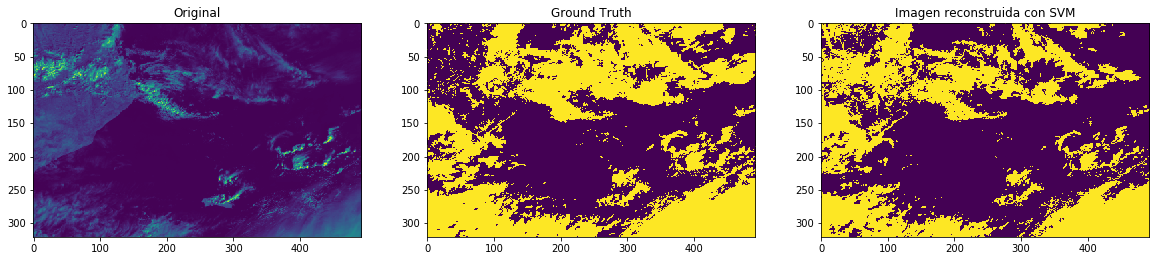

In [33]:
[m, n, k] = X.shape
matriz = np.reshape(X,(m*n,k))
resultado = clf.predict(matriz)
resultado_svm=np.reshape(resultado+1,(m,n))
    
fig, axes = plt.subplots(1, 3, figsize=(20,20))
ax = axes.ravel()

ax[0].imshow(X[:,:,12])
ax[0].set_title("Original")
ax[1].imshow(Y)
ax[1].set_title("Ground Truth")
ax[2].set_title("Imagen reconstruida con SVM")
ax[2].imshow(resultado_svm)

Efectivamente el algoritmo SVM ha detectado correctamente la mayor parte de las nubes independientemente de su densidad, aunque también se aprecian zonas clasificadas como nubes que no lo son (esquina superior izquierda, por ejemplo).

## 3.2 Ensembles

El siguiente enfoque será utilizar métodos de _ensemble learning_, cuyo objetivo es utilizar muchos modelos de aprendizaje automático más simples conjuntamente para obtener un modelo final que posea un rendimiento mayor al de los modelos en solitario. Este tipo de modelos presenta así mejores propiedades estadísticas (en general, reduce el riesgo de obtener predicciones erróneas), mientras que aprovechan la sencillez y bajo coste computacional de los algoritmos de aprendizaje automático más simples.

### 3.2.1 Bagging: Random Forest

Uno de los algoritmos de este tipo más famosos es Random Forest. Random Forest consiste, en líneas generales, en agrupar un gran número de algoritmos predictores más sencillos, llamados “árboles de decisión”, para construir un algoritmo mucho más robusto y certero. Aunque los árboles individuales pueden presentar graves problemas de sobreentrenamiento, al ser promediados para constituir un Random Forest se alcanza una gran capacidad de generalización. Para elegir el número de árboles a utilizar se empleará el *out of bag error* como estimador aproximado del error de test, de modo que se escogerá el número de estimadores que proporcione el menor error o aquel a partir de cual éste no varíe.

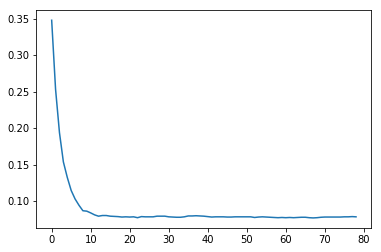

In [34]:
import warnings
warnings.filterwarnings('ignore')
oob_error = np.array([])
for n_estimators in range(1,80):
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=2, random_state=0, oob_score=True)
    #n_estimators coger el que tiene menos error de out bag error
    clf.fit(X_train,y_train)
    oob_error = np.append(oob_error, 1 - clf.oob_score_)

plt.plot(oob_error)

En la gráfica superior se observa cómo el error se mantiene prácticamente constante a partir de los 40 estimadores, por lo que escogemos utilizar este número de estimadores.

In [35]:
rf = RandomForestClassifier(n_estimators=40, max_depth=best_depth, random_state=0)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [36]:
# Analizamos resultados
cm = confusion_matrix(y_test,y_pred)
print("Matriz de confusión: \n", cm)
print("Sensibilidad:", np.round(cm[0,0]/(cm[0,0]+cm[1,0]),4))
print("Especificidad:", np.round(cm[1,1]/(cm[1,1]+cm[0,1]),4))
print("Exactitud:", round(accuracy_score(y_test, y_pred),4))

Matriz de confusión: 
 [[788  39]
 [  9 814]]
Sensibilidad: 0.9887
Especificidad: 0.9543
Exactitud: 0.9709


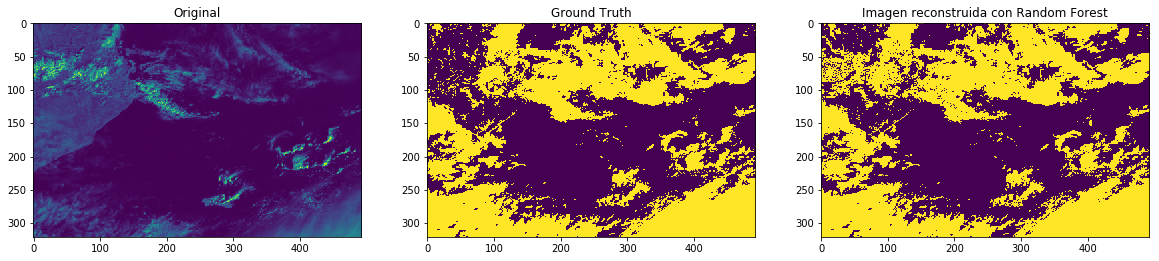

In [37]:
[m, n, k] = X.shape
matriz = np.reshape(X,(m*n,k))
resultado = rf.predict(matriz)
resultado = np.reshape(resultado+1,(m,n))
    
fig, axes = plt.subplots(1, 3, figsize=(20,20))
ax = axes.ravel()

ax[0].imshow(X[:,:,12])
ax[0].set_title("Original")
ax[1].imshow(Y)
ax[1].set_title("Ground Truth")
ax[2].set_title("Imagen reconstruida con Random Forest")
ax[2].imshow(resultado)

Algunas zonas de la tierra se toman como nubes cuando no lo son, motivo por el cual el valor de la especificidad es algo más bajo que el de la sensibilidad o el de la exactitud. Sin embargo, los resultados obtenidos es superior al obtenido con un solo árbol de decisión en todos los aspectos.

### 3.2.2 Boosting: AdaBoost

Las técnicas de boosting se basan también en entrenar varios modelos para formar en conjunto uno solo, pero en este caso cada uno de los modelos individuales depende de la salida de uno anterior para corregir o complementar su decisión, formando una especie de cadena. AdaBoost es uno de los algoritmos más populares de este tipo. En resumen, consiste en disponer de varios entrenadores más sencillos, ponderados por unos pesos, de forma que cada uno contribuye de forma distinta al resultado final. Una característica especial de AdaBoost (que le otorga el nombre de "adaptativo") es que cada nuevo modelo que se añade al conjunto trata de corregir especialmente las muestras que han sido incorrectamente clasificadas por los modelos anteriores.

Para escoger el número de estimadores y la profundidad máxima del árbol de decisión realizamos una _grid search_, entrenando varios modelos con distintos hiperparámetros y calculando su rendimiento. Posteriormente, examinaremos qué combinación nos aporta una mayor exactitud en la clasificación de las muestras de test. El algoritmo seleccionado en el Adaboost será el "SAMME" en todos los casos por su convergencia más exacta e igualmente rápida.

Cabe resaltar que hemos escogido la exactitud en lugar de otras métricas para decidir cuál es el número de estimadores y la profundidad máxima del árbol idónea pues nos da una idea general del rendimiento, sin las desventajas que suele suponer su uso ya que la muestra de datos está balanceada.

In [38]:
scores = []
hiperparams = []
for max_depth in range(1,4):
    for n_estimators in [20,50,100,200]:
        adaB = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                         algorithm="SAMME",
                         n_estimators=n_estimators,random_state=6)
        adaB.fit(X_train,y_train)
        y_pred = adaB.predict(X_test)
        cm = confusion_matrix(y_test,y_pred)
        scores.append(accuracy_score(y_test, y_pred))
        hiperparams.append([max_depth,n_estimators])
max_score = np.argmax(scores)
print("Exactitud con max_depth ",hiperparams[max_score][0]," y ",hiperparams[max_score][1]," estimadores:", round(scores[max_score],4))

Exactitud con max_depth  3  y  200  estimadores: 0.9691


In [39]:
adaB = AdaBoostClassifier(DecisionTreeClassifier(max_depth=hiperparams[max_score][0]),
                         algorithm="SAMME",
                         n_estimators=hiperparams[max_score][1],random_state=6)
adaB.fit(X_train,y_train)
y_pred=adaB.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
print("Matriz de confusión: \n", cm)
print("Sensibilidad:", np.round(cm[0,0]/(cm[0,0]+cm[1,0]),4))
print("Especificidad:", np.round(cm[1,1]/(cm[1,1]+cm[0,1]),4))
print("Exactitud:", round(accuracy_score(y_test, y_pred),4))

Matriz de confusión: 
 [[789  38]
 [ 13 810]]
Sensibilidad: 0.9838
Especificidad: 0.9552
Exactitud: 0.9691


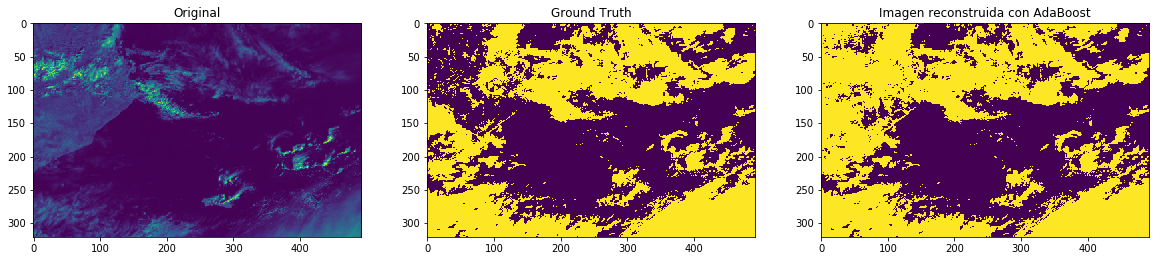

In [40]:
[m, n, k] = X.shape
matriz = np.reshape(X,(m*n,k))
resultado = clf.predict(matriz)
resultado=np.reshape(resultado+1,(m,n))
    
fig, axes = plt.subplots(1, 3, figsize=(20,20))
ax = axes.ravel()

ax[0].imshow(X[:,:,12])
ax[0].set_title("Original")
ax[1].imshow(Y)
ax[1].set_title("Ground Truth")
ax[2].set_title("Imagen reconstruida con AdaBoost")
ax[2].imshow(resultado)

# 4. Selección de características
La imagen hiperespectral puede contener bandas con datos erróneos, o con bandas que tengan poca relevancia en el resultado de la clasificación y puedan llegar a emperorar la misma. Partiendo de esta idea, se intentará detectar cuáles son las bandas que proporcionan más información elaborando un *ranking* y, posteriormente, se eliminarán  aquellas bandas que empeoren (o no mejoren) el resultado de la clasificación. Para poder cuantificar la importancia de cada variable, se hará un "análisis de importancias" a partir del modelo obtenido con *Random Forest*.

## 4.1 Análisis de importancias

Aprovechando el modelo Random Forest que habíamos entrenado anteriormente con todas las características podemos obtener un ranking de importancias muy fácilmente. La "importancia" de cada variable se estima desordenando cada una de las variables y midiendo cómo afecta esto a los resultados. Si la variable era especialmente importante, el aumento del error será muy grande, mientras que si la característica en cuestión apenas jugaba un papel relevante en la clasificación el aumento del error será prácticamente nulo.

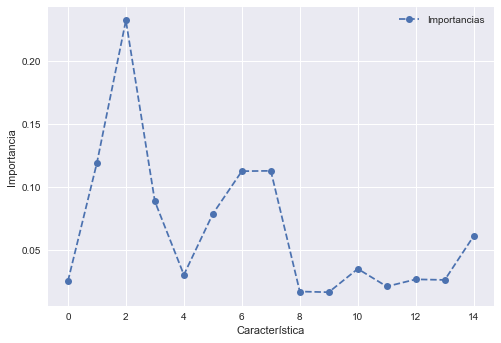

In [41]:
# Obtenemos las importancias de cada característica:
importancias = rf.feature_importances_

# Graficamos las importancias para cada característica
plt.style.use('seaborn')
plt.plot(importancias,'--o', label = 'Importancias')
plt.ylabel('Importancia')
plt.xlabel('Característica')
plt.legend(loc = 'best')
plt.show() 

Para llevar a cabo un *ranking* y seleccionar las características, estableceremos un umbral de importancia al 0.01 de modo que aquellas variables cuya importancia no supere ese umbral serán eliminadas.

Las bandas ordenadas por importancia son:  [ 2  1  7  6  3  5 14 10  4 12 13  0 11  8  9]


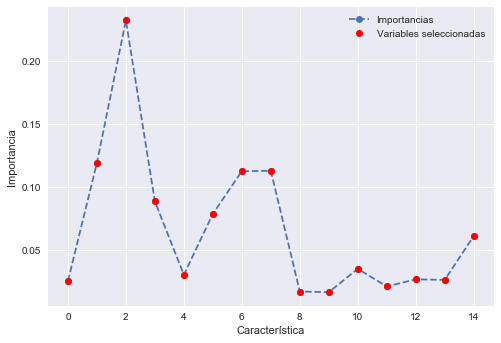

In [42]:
feats_subset = importancias>0.01
ranking_feats=np.argsort(importancias)[::-1]
print("Las bandas ordenadas por importancia son: ",np.array(range(15))[ranking_feats])

plt.style.use('seaborn')
plt.plot(importancias,'--o', label = 'Importancias')
plt.plot(np.array(range(15))[feats_subset],importancias[feats_subset],'o', label = 'Variables seleccionadas',color='red')
plt.ylabel('Importancia')
plt.xlabel('Característica')
plt.legend(loc='best')
plt.show() 

In [44]:
np.random.seed(666)
mat_red = matriz_under[:,feats_subset]
X_train, X_test, y_train, y_test = train_test_split(mat_red, labels_under, test_size=.33, shuffle = True)

## 4.2 Entrenamiento de nuevos clasificadores

Con el fin de comprobar si esta selección de características mejora los resultados de los modelos, probaremos a reentrenar en primer lugar el modelo *Support Vector Machine* y examinar tanto cuantitativa como cualitativamente los resultados obtenidos.

### 4.2.1 Support Vector Machine

In [43]:
#En este caso seleccionamos el kernel rbf porque el lineal es demasiado simple para nuestro modelo y el poli demasiado complejo
np.random.set_state(estado_svm)
clf = SVC(kernel = 'rbf', gamma = 'auto')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Analizamos resultados empleando las mismas métricas que anteriormente
cm = confusion_matrix(y_test,y_pred)
print("Matriz de confusión: \n", cm)
print("Sensibilidad:", np.round(cm[0,0]/(cm[0,0]+cm[1,0]),4))
print("Especificidad:", np.round(cm[1,1]/(cm[1,1]+cm[0,1]),4))
print("Exactitud:", round(accuracy_score(y_test, y_pred),4))

Matriz de confusión: 
 [[760  67]
 [213 610]]
Sensibilidad: 0.7811
Especificidad: 0.901
Exactitud: 0.8303


Las métricas han obtenido valores más altos para el modelo, con lo que podríamos decir que la selección de características ha logrado mejorar el modelo. Veamos el resultado de forma cualitativa:

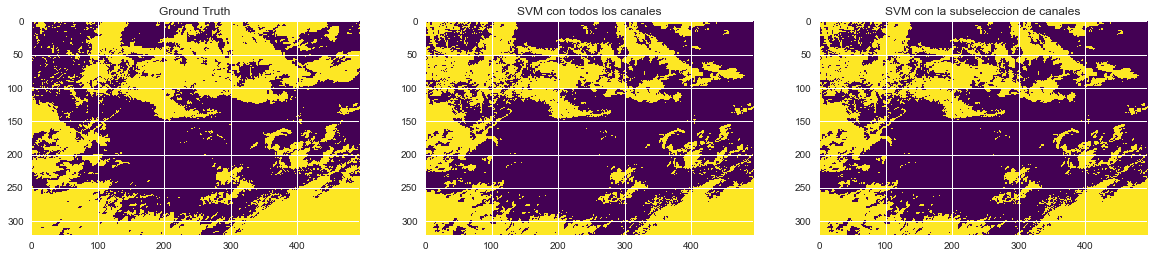

In [44]:
resultado = clf.predict(matriz[:,feats_subset])
resultado = np.reshape(resultado+1,(m,n))
    
fig, axes = plt.subplots(1, 3, figsize=(20,20))
ax = axes.ravel()

ax[0].imshow(Y, cmap=plt.get_cmap("viridis"))
ax[0].set_title("Ground Truth")
ax[1].set_title("SVM con todos los canales")
ax[1].imshow(resultado_svm, cmap=plt.get_cmap("viridis"))
ax[2].set_title("SVM con la subseleccion de canales")
ax[2].imshow(resultado, cmap=plt.get_cmap("viridis"))

Al comparar la imagen resultante con el modelo SVM usando todos los canales frente al SVM con los seleccionados no se aprecian prácticamente diferencias, lo que significa que la extracción de características ha sido buena, pues aunque aparentemente no haya mejorado el resultado, se ha logrado reducir la dimensionalidad manteniendo el mismo poder predictor.

### 4.2.2 Random Forest

Volvemos a obtener la curva del _oob-error_ por si esta hubiese cambiado al seleccionar un conjunto menor de características:

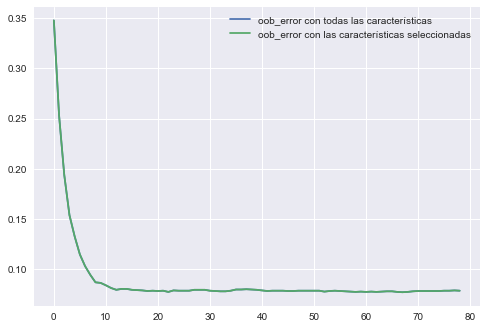

In [47]:
warnings.filterwarnings('ignore')
oob_error1 = np.array([])
for n_estimators in range(1,80):
    clf = RandomForestClassifier(n_estimators = n_estimators, max_depth=2, random_state=0, oob_score=True)
    #n_estimators coger el que tiene menos error de out bag error
    clf.fit(X_train,y_train)
    oob_error1 = np.append(oob_error1, 1 - clf.oob_score_)

plt.plot(oob_error, label = "oob_error con todas las características")
plt.plot(oob_error1, label = "oob_error con las características seleccionadas")
plt.legend()
plt.show()

La curva apenas ha cambiado, por lo que utilizaremos de nuevo 40 estimadores.

In [48]:
rf = RandomForestClassifier(n_estimators=20, max_depth=best_depth, random_state=0)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

# Analizamos resultados
cm = confusion_matrix(y_test,y_pred)
print("Matriz de confusión: \n", cm)
print("Sensibilidad:", np.round(cm[0,0]/(cm[0,0]+cm[1,0]),4))
print("Especificidad:", np.round(cm[1,1]/(cm[1,1]+cm[0,1]),4))
print("Exactitud:", round(accuracy_score(y_test, y_pred),4))

Matriz de confusión: 
 [[787  40]
 [ 13 810]]
Sensibilidad: 0.9838
Especificidad: 0.9529
Exactitud: 0.9679


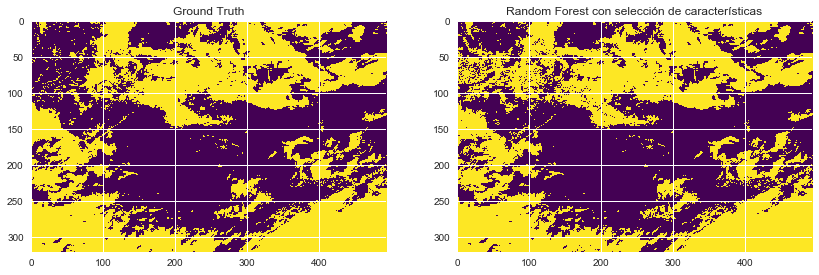

In [49]:
resultado = rf.predict(matriz[:,feats_subset])
resultado = np.reshape(resultado+1,(m,n))
    
fig, axes = plt.subplots(1, 2, figsize = (14,14))
ax = axes.ravel()

ax[0].imshow(Y,cmap=plt.get_cmap("viridis"))
ax[0].set_title("Ground Truth")
ax[1].set_title("Random Forest con selección de características")
ax[1].imshow(resultado,cmap=plt.get_cmap("viridis"))

Si comparamos los resultados con los obtenidos anteriormente al usar todas las características, vemos que aunque han empeorado, se trata de un cambio del orden de las milésimas, inapreciable en la imagen resultante, por lo que la selección de características podría estar bien indicada.

### 4.2.3 Adaboost

In [50]:
scores = []
hiperparams = []
for max_depth in range(1,4):
    for n_estimators in [20,50,100,200]:
        adaB = AdaBoostClassifier(DecisionTreeClassifier(max_depth = max_depth),
                         algorithm = "SAMME",
                         n_estimators = n_estimators,random_state = 6)
        adaB.fit(X_train,y_train)
        y_pred = adaB.predict(X_test)
        cm = confusion_matrix(y_test,y_pred)
        scores.append(accuracy_score(y_test, y_pred))
        hiperparams.append([max_depth,n_estimators])
max_score = np.argmax(scores)
print("Exactitud con max_depth ",hiperparams[max_score][0]," y ",hiperparams[max_score][1]," estimadores:", round(scores[max_score],4))

Exactitud con max_depth  3  y  200  estimadores: 0.9691


In [51]:
adaB = AdaBoostClassifier(DecisionTreeClassifier(max_depth = hiperparams[max_score][0]),
                         algorithm = "SAMME",
                         n_estimators = hiperparams[max_score][1],random_state=6)
adaB.fit(X_train,y_train)
y_pred = adaB.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
print("Matriz de confusión: \n", cm)
print("Sensibilidad:", np.round(cm[0,0]/(cm[0,0]+cm[1,0]),4))
print("Especificidad:", np.round(cm[1,1]/(cm[1,1]+cm[0,1]),4))
print("Exactitud:", round(accuracy_score(y_test, y_pred),4))

Matriz de confusión: 
 [[789  38]
 [ 13 810]]
Sensibilidad: 0.9838
Especificidad: 0.9552
Exactitud: 0.9691


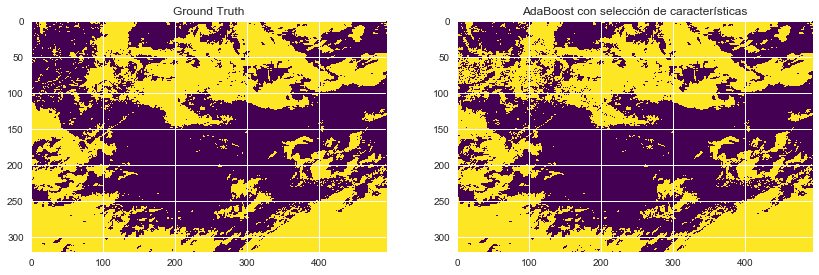

In [52]:
resultado = rf.predict(matriz[:,feats_subset])
resultado = np.reshape(resultado+1,(m,n))
    
fig, axes = plt.subplots(1, 2, figsize = (14,14))
ax = axes.ravel()

ax[0].imshow(Y,cmap=plt.get_cmap("viridis"))
ax[0].set_title("Ground Truth")
ax[1].set_title("AdaBoost con selección de características")
ax[1].imshow(resultado,cmap=plt.get_cmap("viridis"))

La conclusión que extraemos con AdaBoost es idéntica, pues apenas se notan cambios tanto cuantitativa como cualitativamente.

# 5. Conclusiones

Una primera conclusión general extraída tras observar los resultados de todos los clasificadores es que los algoritmos de aprendizaje supervisado han demostrado proporcionar resultados mucho más satisfactorios que los obtenidos con algoritmos de aprendizaje no supervisado. Sin embargo, cabe tener en cuenta que los supervisados requieren de la elaboración manual de un _groundtruth_ por parte de un experto, que en muchos casos se trata de un proceso muy largo y costoso. Por tanto, los resultados de k-Means, más o menos aceptables, podrían utilizarse como una primera aproximación del _groundtruth_ de la imagen que un experto tardaría un tiempo menor en corregir que en crearlo desde cero.

Cabe resaltar también los buenos resultados obtenidos con modelos simples como K-vecinos o árboles de decisión, tan solo superados por los algoritmos basados en _ensembles_, lo cual podría significar que no se trata de un caso especialmente complejo.

Otro aspecto que cabe mencionar es la importancia de los métodos de selección de características, que en ciertos problemas pueden resultar útiles para reducir su complejidad, lo que conlleva a su vez una reducción del coste y tiempo computacional  e incluso una mejora en los resultados, así como un incremento en la facilidad de interpretación en algunos casos. En este caso, se ha seleccionado un conjunto menor de características a partir de un ránking de importancias y, aunque los resultados no han mejorado, tampoco se han visto perjudicados, por lo que podría considerarse un procedimiento exitoso.

Es importante conocer que, para poder profundizar más y obtener conclusiones más consistentes acerca del problema planteado, sería necesario disponer de más información acerca de los datos, como por ejemplo la información contenida en cada una de las bandas, o información precisa sobre cuál es el problema que se está abordando, pues el significado de las distintas clases ha sido interpretado subjetivamente.